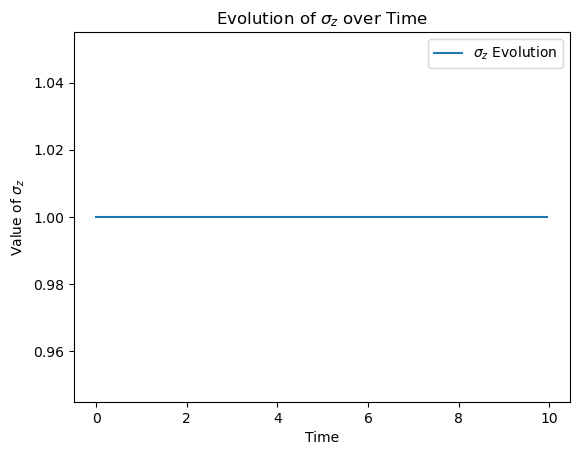

In [1]:
from qiskit import QuantumCircuit, Aer, execute, transpile
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Time parameters
dt = 0.05  # Time step for the simulation
time_steps = 200  # Total number of time steps for the simulation
J_ij = 1  # Interaction strength, assuming a constant value for simplicity
N = 4 #qubits 
# Backend selection for simulation
backend = Aer.get_backend('aer_simulator')
shots = 1024

# Function to create the quantum circuit with specific alpha value
def create_circuit(alpha_value):
    qc = QuantumCircuit(N, N)  # Adjusted for 4 qubits and classical bits
    alpha_value = -dt * J_ij  # This might be recalculated for each pair or step if needed
    
    # Apply the RXX, RYY, and RZZ gates with theta = 2 * alpha across pairs of qubits
    # Assuming a linear chain or ring of qubits for interactions
    for i in range(N-1):  # Adjust to apply gates across adjacent pairs
        qc.rxx(2 * alpha_value, i, i+1)
        qc.ryy(2 * alpha_value, i, i+1)
        qc.rzz(2 * alpha_value, i, i+1)

    # Additional interactions for a ring-like structure (optional, remove if not needed)
    # qc.rxx(2 * alpha_value, N, 0)
    # qc.ryy(2 * alpha_value, N, 0)
    # qc.rzz(2 * alpha_value, N, 0)

    # Measure in the computational basis
    qc.measure(range(N), range(N))
    
    return qc

# Simulation and expectation value calculation
sigma_z_values = []

for step in range(time_steps):
    # Calculate alpha for the current time step
    alpha_value = -dt * J_ij * step
    
    # Create and execute the circuit with the current alpha value
    qc = create_circuit(alpha_value)
    transpiled_qc = transpile(qc, backend)
    result = execute(transpiled_qc, backend, shots=shots).result()
    counts = result.get_counts(qc)
    
    # Calculate expectation value of sigma_z for this step
    sigma_z = 0
    for outcome in counts:
        # Convert the outcome to sigma_z contributions
        sigma_z_contribution = sum([1 if bit == '0' else -1 for bit in outcome]) / N  # Adjusted for 4 qubits
        sigma_z += sigma_z_contribution * counts[outcome] / shots
    sigma_z_values.append(sigma_z)

# Plotting the evolution of sigma_z over time
time_array = np.arange(0, time_steps*dt, dt)
plt.plot(time_array, sigma_z_values, label='$\\sigma_z$ Evolution')
plt.xlabel('Time')
plt.ylabel('Value of $\\sigma_z$')
plt.title('Evolution of $\\sigma_z$ over Time')
plt.legend()
plt.show()

